# Deblending

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from scipy.sparse.linalg import lobpcg as sp_lobpcg
from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.blending  import *

In [2]:
import numpy as np

from pylops import LinearOperator
from pylops.basicoperators import BlockDiag, HStack, Pad
from pylops.signalprocessing import Shift
from pylops.utils.backend import get_array_module
from pylops.utils.decorators import reshaped
from pylops.utils.typing import DTypeLike, NDArray


class BlendingContinuousOLD(LinearOperator):
    r"""Continuous blending operator

    Blend seismic shot gathers in continuous mode based on pre-defined sequence of firing times.
    The size of input model vector must be :math:`n_s \times n_r \times n_t`, whilst the size of the data
    vector is :math:`n_r \times n_{t,tot}`.

    Parameters
    ----------
    nt : :obj:`int`
        Number of time samples
    nr : :obj:`int`
        Number of receivers
    ns : :obj:`int`
        Number of sources
    dt : :obj:`float`
        Time sampling in seconds
    times : :obj:`np.ndarray`
        Absolute ignition times for each source
    nproc : :obj:`int`, optional
        Number of processors used when applying operator
    dtype : :obj:`str`, optional
        Operator dtype
    name : :obj:`str`, optional
        Name of operator (to be used by :func:`pylops.utils.describe.describe`)

    Notes
    -----
    Simultaneous shooting or blending is the process of acquiring seismic data firing consecutive sources
    at short time intervals (shorter than the time requires for all significant waves to come back from the Earth
    interior).

    Continuous blending refers to an acquisition scenario where a source towed behind a single vessel is fired at
    irregular time intervals (``times``) to create a continuous recording whose modelling operator is

      .. math::
        \Phi = [\Phi_1, \Phi_2, ..., \Phi_N]

    where each :math:`\Phi_i` operator applies a time-shift equal to the absolute ignition time provided in the
    variable ``times``.

    """

    def __init__(
        self,
        nt: int,
        nr: int,
        ns: int,
        dt: float,
        times: NDArray,
        dtype: DTypeLike = "float64",
        name: str = "B",
    ) -> None:
        self.dtype = np.dtype(dtype)
        self.nt = nt
        self.nr = nr
        self.ns = ns
        self.dt = dt
        self.times = times
        self.nttot = int(np.max(self.times) / self.dt + self.nt + 1)
        self.PadOp = Pad((self.nr, self.nt), ((0, 0), (0, 1)), dtype=self.dtype)
        # Define shift operators
        self.shifts = []
        self.ShiftOps = []
        for i in range(self.ns):
            shift = self.times[i]
            # This is the part that fits on the grid
            shift_int = int(shift // self.dt)
            self.shifts.append(shift_int)
            # This is the fractional part
            diff = (shift / self.dt - shift_int) * self.dt
            if diff == 0:
                self.ShiftOps.append(None)
            else:
                self.ShiftOps.append(
                    Shift(
                        (self.nr, self.nt + 1),
                        diff,
                        axis=1,
                        sampling=self.dt,
                        real=False,
                        dtype=self.dtype,
                    )
                )
        super().__init__(
            dtype=np.dtype(dtype),
            dims=(self.ns, self.nr, self.nt),
            dimsd=(self.nr, self.nttot),
            name=name,
        )

    @reshaped
    def _matvec(self, x: NDArray) -> NDArray:
        ncp = get_array_module(x)
        blended_data = ncp.zeros((self.nr, self.nttot), dtype=self.dtype)
        for i, shift_int in enumerate(self.shifts):
            if self.ShiftOps[i] is None:
                blended_data[:, shift_int : shift_int + self.nt] += x[i, :, :]
            else:
                shifted_data = self.ShiftOps[i] * self.PadOp * x[i, :, :]
                blended_data[:, shift_int : shift_int + self.nt + 1] += shifted_data
        return blended_data

    @reshaped
    def _rmatvec(self, x: NDArray) -> NDArray:
        ncp = get_array_module(x)
        deblended_data = ncp.zeros((self.ns, self.nr, self.nt), dtype=self.dtype)
        for i, shift_int in enumerate(self.shifts):
            if self.ShiftOps[i] is None:
                deblended_data[i, :, :] = x[:, shift_int : shift_int + self.nt]
            else:
                shifted_data = (
                    self.PadOp.H
                    * self.ShiftOps[i].H
                    * x[:, shift_int : shift_int + self.nt + 1]
                )
                deblended_data[i, :, :] = shifted_data
        return deblended_data


In [3]:
import numpy as np

from pylops import LinearOperator
from pylops.basicoperators import BlockDiag, HStack, Pad
from pylops.signalprocessing import Shift
from pylops.utils.backend import get_array_module
from pylops.utils.decorators import reshaped
from pylops.utils.typing import DTypeLike, NDArray


class BlendingContinuousFast(LinearOperator):
    r"""Continuous blending operator

    Blend seismic shot gathers in continuous mode based on pre-defined sequence of firing times.
    The size of input model vector must be :math:`n_s \times n_r \times n_t`, whilst the size of the data
    vector is :math:`n_r \times n_{t,tot}`.

    Parameters
    ----------
    nt : :obj:`int`
        Number of time samples
    nr : :obj:`int`
        Number of receivers
    ns : :obj:`int`
        Number of sources
    dt : :obj:`float`
        Time sampling in seconds
    times : :obj:`np.ndarray`
        Absolute ignition times for each source
    nproc : :obj:`int`, optional
        Number of processors used when applying operator
    dtype : :obj:`str`, optional
        Operator dtype
    name : :obj:`str`, optional
        Name of operator (to be used by :func:`pylops.utils.describe.describe`)

    Notes
    -----
    Simultaneous shooting or blending is the process of acquiring seismic data firing consecutive sources
    at short time intervals (shorter than the time requires for all significant waves to come back from the Earth
    interior).

    Continuous blending refers to an acquisition scenario where a source towed behind a single vessel is fired at
    irregular time intervals (``times``) to create a continuous recording whose modelling operator is

      .. math::
        \Phi = [\Phi_1, \Phi_2, ..., \Phi_N]

    where each :math:`\Phi_i` operator applies a time-shift equal to the absolute ignition time provided in the
    variable ``times``.

    """

    def __init__(
        self,
        nt: int,
        nr: int,
        ns: int,
        dt: float,
        times: NDArray,
        dtype: DTypeLike = "float64",
        name: str = "B",
    ) -> None:
        self.dtype = np.dtype(dtype)
        self.nt = nt
        self.nr = nr
        self.ns = ns
        self.dt = dt
        self.times = times
        self.nttot = int(np.max(self.times) / self.dt + self.nt + 1)
        self.PadOp = Pad((self.ns, self.nr, self.nt), ((0, 0), (0, 0), (0, 1)), dtype=self.dtype)
        # Define shift operator
        self.shifts = (times // self.dt).astype(np.int32)
        diff = (times / self.dt - self.shifts) * self.dt
        diff = np.repeat(diff[:, np.newaxis], self.nr, axis=1)
        self.ShiftOp = \
            Shift((self.ns, self.nr, self.nt + 1),
                   diff,
                   axis=-1,
                   sampling=self.dt,
                   real=False,
                   dtype=self.dtype,
            )
        
        super().__init__(
            dtype=np.dtype(dtype),
            dims=(self.ns, self.nr, self.nt),
            dimsd=(self.nr, self.nttot),
            name=name,
        )

    @reshaped
    def _matvec(self, x: NDArray) -> NDArray:
        ncp = get_array_module(x)
        blended_data = ncp.zeros((self.nr, self.nttot), dtype=self.dtype)
        shifted_data = self.ShiftOp._matvec(self.PadOp._matvec(x.ravel())).reshape(self.ns, self.nr, self.nt + 1)
        for i, shift_int in enumerate(self.shifts):
            blended_data[:, shift_int : shift_int + self.nt + 1] += shifted_data[i]
        return blended_data

    @reshaped
    def _rmatvec(self, x: NDArray) -> NDArray:
        ncp = get_array_module(x)
        shifted_data = ncp.zeros((self.ns, self.nr, self.nt + 1), dtype=self.dtype)
        for i, shift_int in enumerate(self.shifts):
            shifted_data[i, :, :] = x[:, shift_int : shift_int + self.nt + 1]
        deblended_data = self.PadOp._rmatvec(self.ShiftOp._rmatvec(shifted_data.ravel())).reshape(self.dims)
        return deblended_data

Load the data

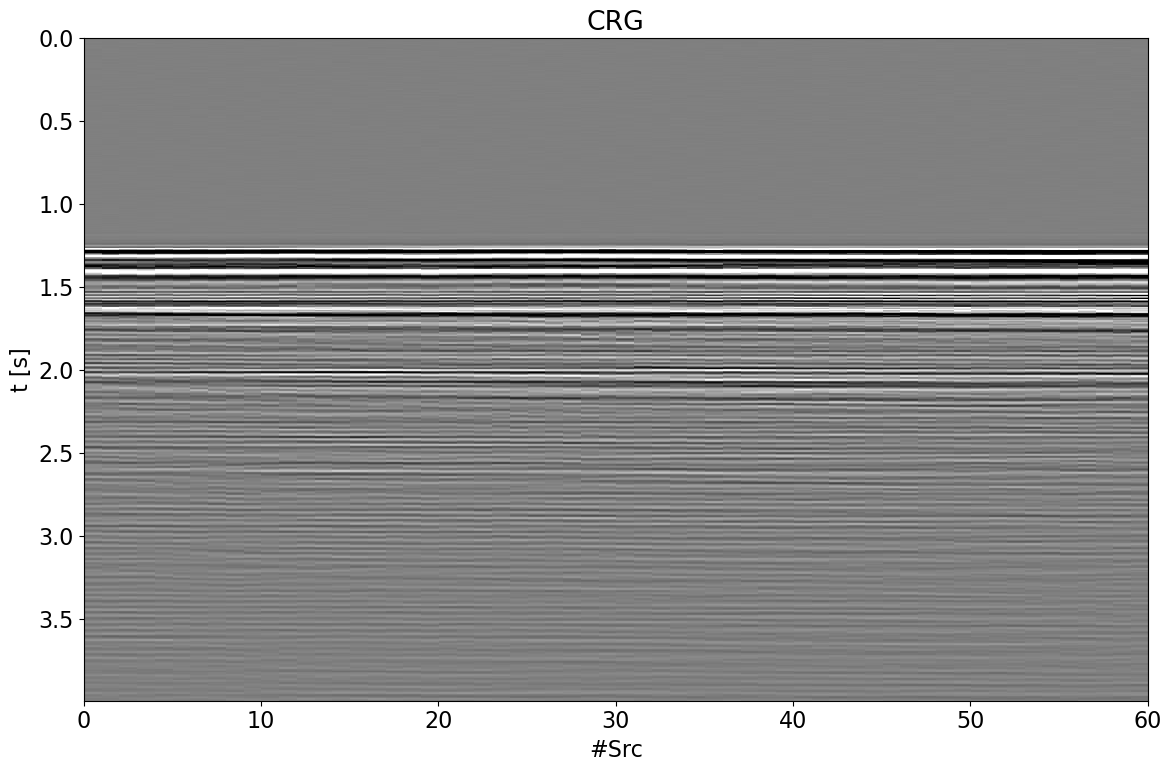

In [4]:
data = np.load("../../pylops/testdata/deblending/mobil.npy")
ns, nt = data.shape

dt = 0.004
t = np.arange(nt) * dt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data.T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout();

## Continuous blending single receiver

Dot test passed, v^H(Opu)=(328.372616939998+8.600199900096886e-14j) - u^H(Op^Hv)=(328.37261693999864-2.6883521250828616e-14j)


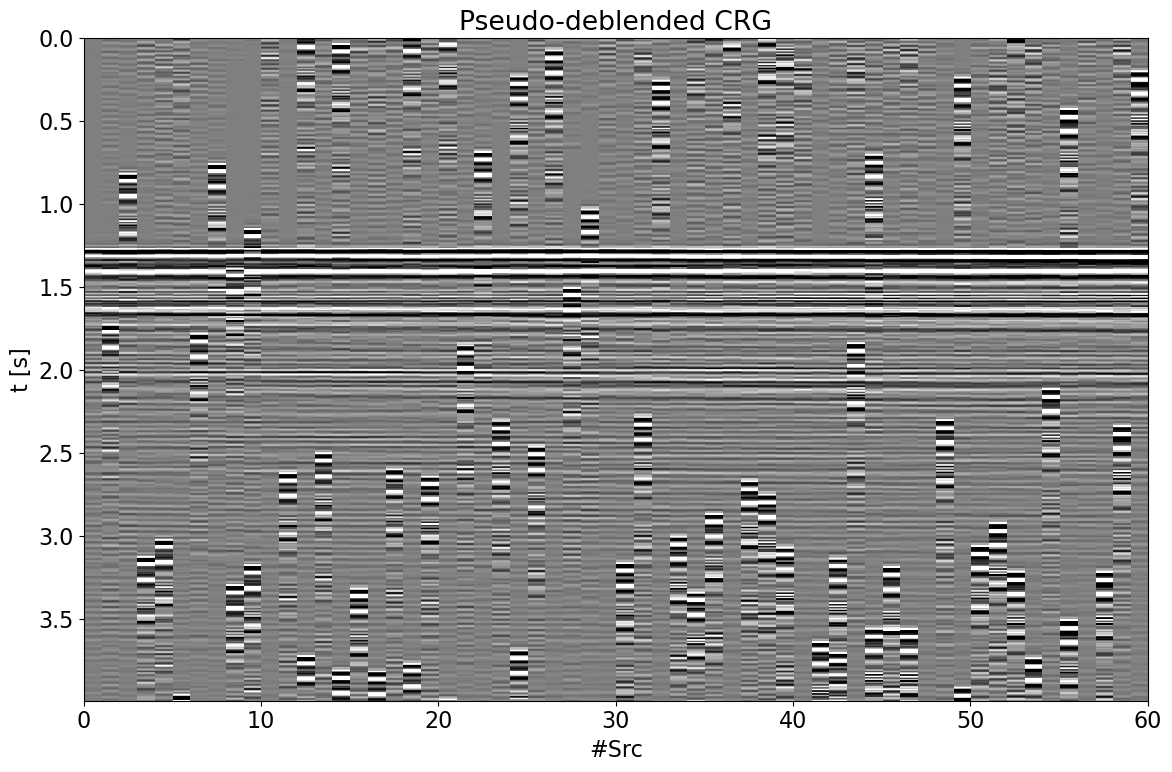

In [5]:
overlap = 0.5
ignition_times = 2.0 * np.random.rand(ns) - 1.0
ignition_times1 = np.arange(0, overlap * nt * ns, overlap * nt) * dt + ignition_times
ignition_times1[0] = 0.
Bop = BlendingContinuousOLD(nt, 1, ns, dt, ignition_times1, dtype="complex128")
dottest(Bop, verb=True)

data_blended = Bop * data[:, np.newaxis]
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

Dot test passed, v^H(Opu)=-134.77476542171348 - u^H(Op^Hv)=-134.77476542171382


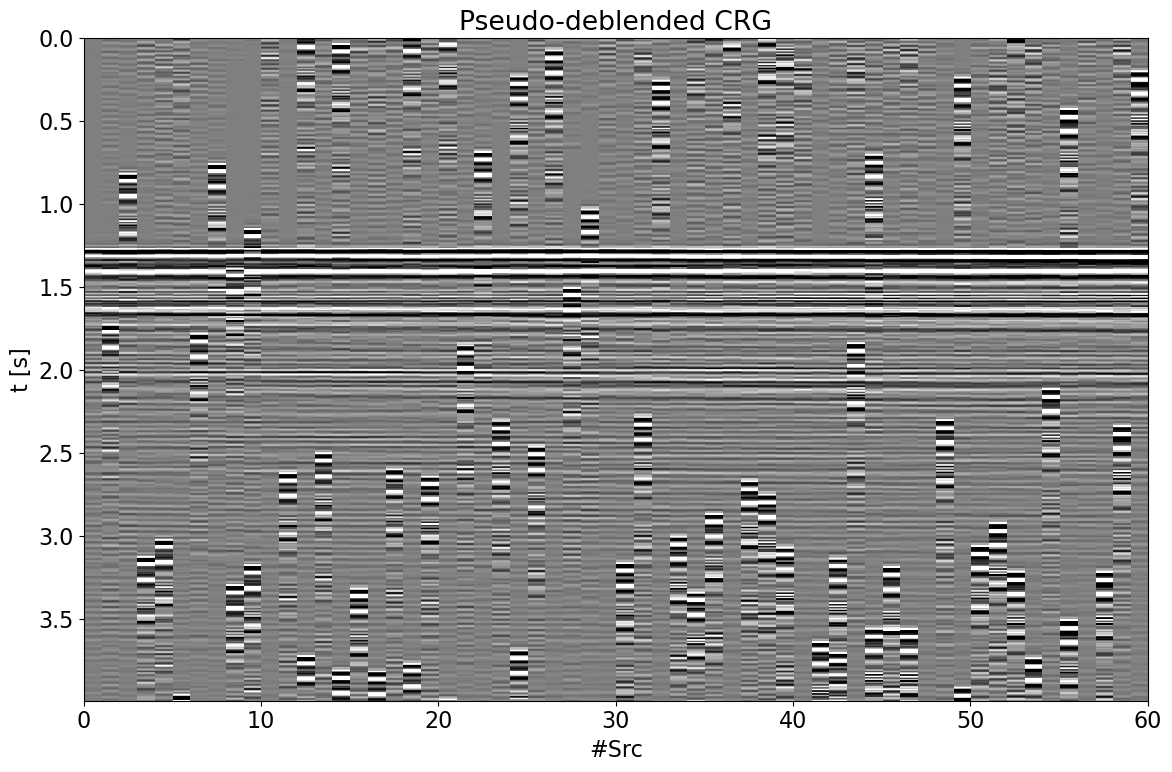

In [6]:
Bop1 = BlendingContinuous(nt, 1, ns, dt, ignition_times1, shiftall=True, dtype="float64")
#Bop1 = BlendingContinuousFast(nt, 1, ns, dt, ignition_times1, dtype="complex128")
dottest(Bop1, verb=True)

data_blended1 = Bop1 * data[:, np.newaxis]
data_pseudo1 = Bop1.H * data_blended1

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo1.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

In [7]:
np.allclose(data_blended, data_blended1), np.allclose(data_pseudo, data_pseudo1)

(True, True)

In [8]:
%timeit -n 2 -r 2 Bop * data[:, np.newaxis]
%timeit -n 2 -r 2 Bop1 * data[:, np.newaxis]

7.9 ms ± 148 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
1.31 ms ± 115 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [9]:
%timeit -n 2 -r 2 Bop.H * data_blended
%timeit -n 2 -r 2 Bop1.H * data_blended1

15.2 ms ± 27.2 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
1.58 ms ± 75.3 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


## Continuous blending multiple receivers

In [10]:
nr = 30
data1 = np.repeat(data[:, np.newaxis, :], nr, axis=1)
data1[:, 1] *= -1
data1[:, 3] *= -1
print(data1.shape)

(60, 30, 1000)


Dot test passed, v^H(Opu)=(-451.84500387774386+1.7781340590870366e-13j) - u^H(Op^Hv)=(-451.8450038777104+3.097861972843637e-14j)


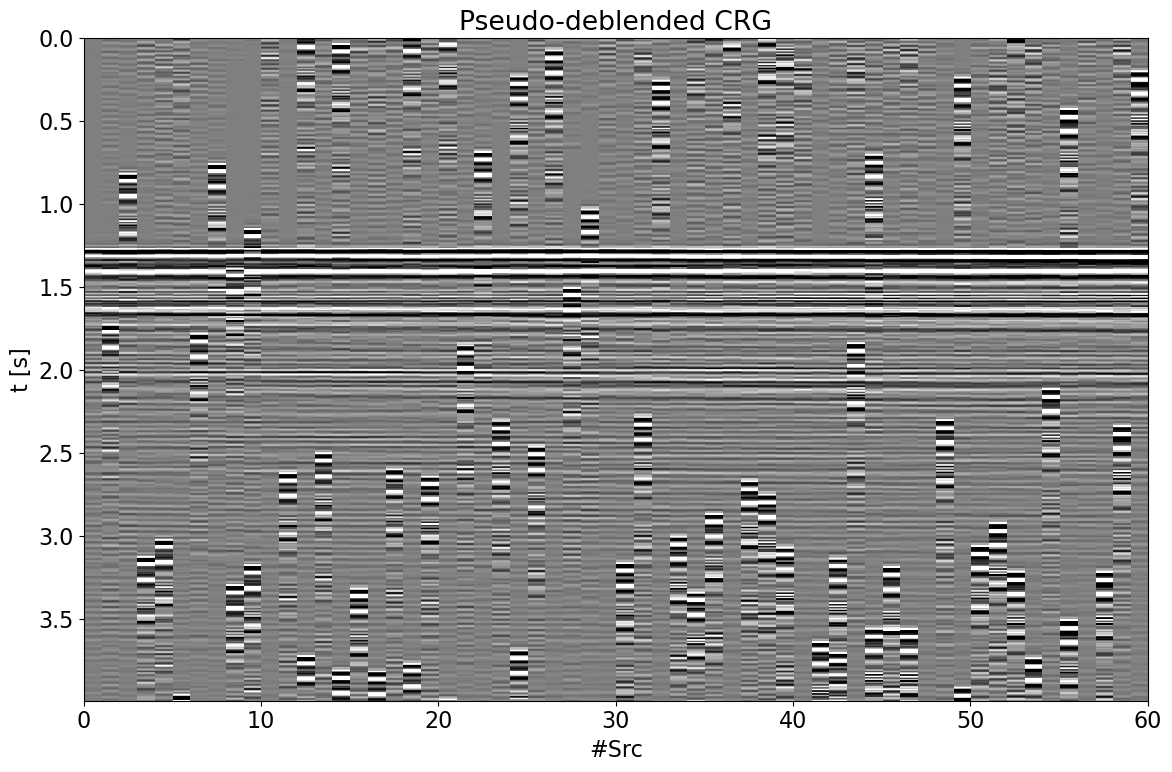

In [11]:
Bop = BlendingContinuousOLD(nt, nr, ns, dt, ignition_times1,  dtype="complex128")
dottest(Bop, verb=True)

data_blended = Bop * data1
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo[:, 0].squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

In [12]:
data_pseudo[:, 0]+data_pseudo[:, 1], data_pseudo[:, 0]-data_pseudo[:, 2], data_pseudo[:, 0]+data_pseudo[:, 3]

(array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+

Dot test passed, v^H(Opu)=-535.9592625736202 - u^H(Op^Hv)=-535.9592625736182


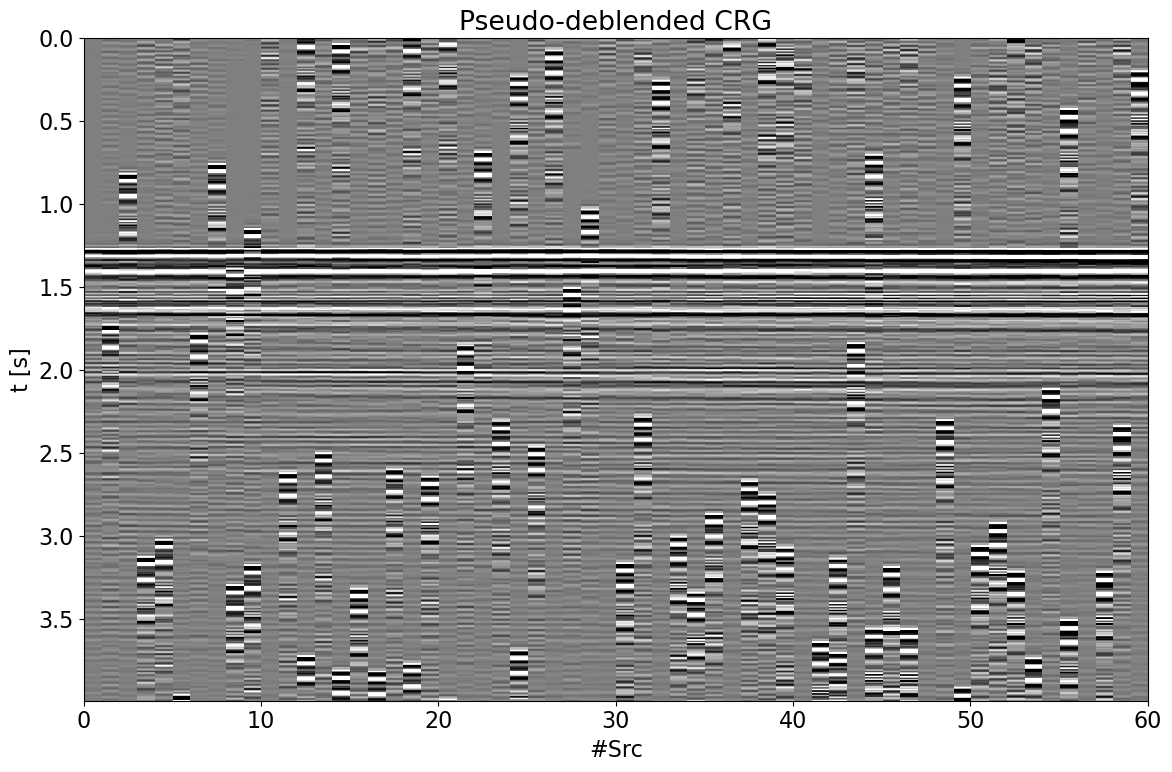

In [13]:
Bop1 = BlendingContinuous(nt, nr, ns, dt, ignition_times1, shiftall=True, dtype="float64")
# Bop1 = BlendingContinuousFast(nt, nr, ns, dt, ignition_times1, dtype="complex128")
dottest(Bop1, verb=True)

data_blended1 = Bop1 * data1
data_pseudo1 = Bop1.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo1[:, 0].squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

In [14]:
np.allclose(data_blended, data_blended1), np.allclose(data_pseudo, data_pseudo1)

(True, True)

In [15]:
%timeit -n 4 -r 3 Bop * data1
%timeit -n 4 -r 3 Bop1 * data1

42.1 ms ± 1.28 ms per loop (mean ± std. dev. of 3 runs, 4 loops each)
30.6 ms ± 678 µs per loop (mean ± std. dev. of 3 runs, 4 loops each)


In [16]:
%timeit -n 4 -r 3 Bop.H * data_blended
%timeit -n 4 -r 3 Bop1.H * data_blended1

56.9 ms ± 741 µs per loop (mean ± std. dev. of 3 runs, 4 loops each)
47.9 ms ± 11.2 ms per loop (mean ± std. dev. of 3 runs, 4 loops each)


## Continuous blending single receiver and many shots (mimic 3d)

In [17]:
nsother = 10
data3d = np.repeat(data[:, np.newaxis, :], nsother, axis=1)
print(data3d.shape)

data3d = data3d.reshape(ns*nsother, nt)
print(data3d.shape)

(60, 10, 1000)
(600, 1000)


Dot test passed, v^H(Opu)=(1179.2224538657301+0j) - u^H(Op^Hv)=(1179.222453865741+0j)


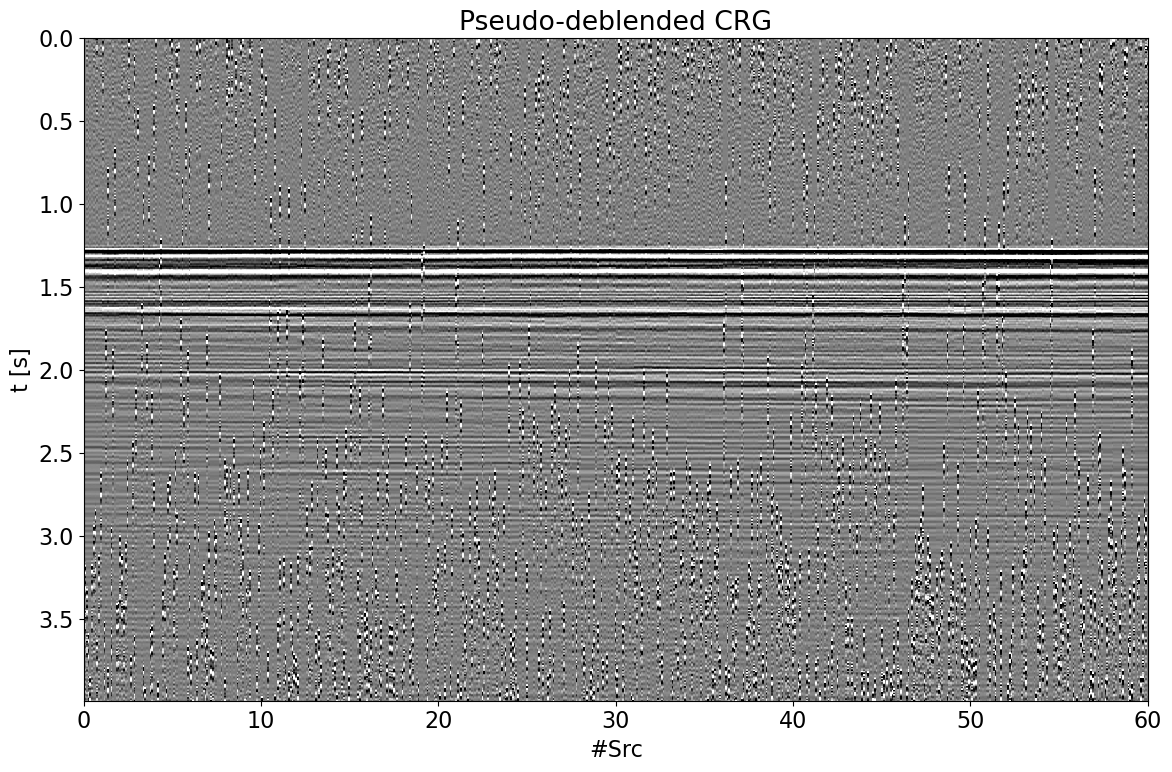

In [18]:
overlap = 0.5
ignition_times = 2.0 * np.random.rand(ns*nsother) - 1.0
ignition_times1 = np.arange(0, overlap * nt * ns * nsother, overlap * nt) * dt + ignition_times
ignition_times1[0] = 0.
#Bop = BlendingContinuousOLD(nt, 1, ns*nsother, dt, ignition_times1, dtype="complex128")
Bop = BlendingContinuous(nt, 1, ns*nsother, dt, ignition_times1, shiftall=False, dtype="complex128")
dottest(Bop, verb=True)

data_blended = Bop * data3d[:, np.newaxis]
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

Dot test passed, v^H(Opu)=(141.71953078366118+0j) - u^H(Op^Hv)=141.71953078365442


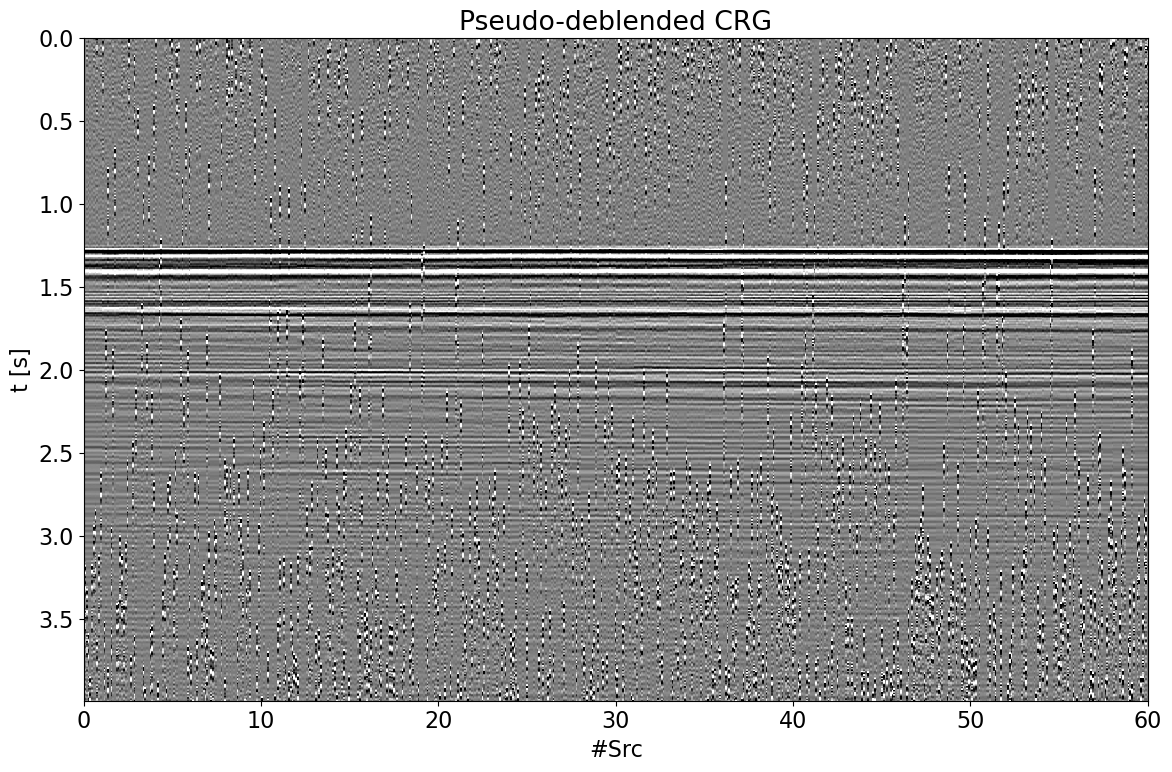

In [19]:
#Bop1 = BlendingContinuousFast(nt, 1, ns*nsother, dt, ignition_times1, dtype="complex128")
Bop1 = BlendingContinuous(nt, 1, ns*nsother, dt, ignition_times1, shiftall=True, dtype="complex128")
dottest(Bop1, verb=True)

data_blended1 = Bop1 * data3d[:, np.newaxis]
data_pseudo1 = Bop1.H * data_blended1

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

In [20]:
np.allclose(data_blended, data_blended1), np.allclose(data_pseudo, data_pseudo1)

(True, True)

In [21]:
%timeit -n 4 -r 3 Bop * data3d[:, np.newaxis]
%timeit -n 4 -r 3 Bop1 * data3d[:, np.newaxis]

69.2 ms ± 8.02 ms per loop (mean ± std. dev. of 3 runs, 4 loops each)
22.4 ms ± 5.84 ms per loop (mean ± std. dev. of 3 runs, 4 loops each)


In [22]:
%timeit -n 4 -r 3 Bop.H * data_blended
%timeit -n 4 -r 3 Bop1.H * data_blended1

51.7 ms ± 1.14 ms per loop (mean ± std. dev. of 3 runs, 4 loops each)
15.1 ms ± 916 µs per loop (mean ± std. dev. of 3 runs, 4 loops each)


## Conclusion:
    
- the new operator is much better for single receiver but gets worse and worse the more receivers we add... In 3D for one single receiver gather, doing the same trick of flattening sources would make the new operator much faster than the old one.